# FlowSim vs NS3: Per-Flow FCT Prediction Analysis

This notebook compares per-flow Flow Completion Time (FCT) predictions between FlowSim and NS3 using **index-based matching**.

**Key Insight**: Both simulators run the same workload (microAllReduce_16gpus.txt), so Flow[i] in NS3 corresponds to Flow[i] in FlowSim (same logical communication pattern).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

## Load and Match FCT Data by Index (Logical Flow Position)

In [3]:
def load_fct_data(filepath):
    """
    Load FCT data preserving file order for index-based matching.
    Format: src_node dst_node src_port dst_port msg_size start_time fct_ns standalone_fct flow_id
    """
    data = []
    with open(filepath, 'r') as f:
        for index, line in enumerate(f):
            if line.strip():
                parts = line.strip().split()
                if len(parts) >= 9:
                    # Convert hex src/dst to int, extract key info
                    src = int(parts[0], 16)
                    dst = int(parts[1], 16) 
                    msg_size = int(parts[4])      # Column 5: message size
                    start_time = int(parts[5])    # Column 6: start time
                    fct_ns = int(parts[6])        # Column 7: actual FCT
                    flow_id = int(parts[8])       # Column 9: flow_id (for reference only)
                    data.append([index, fct_ns, src, dst, msg_size, start_time, flow_id])
    
    return pd.DataFrame(data, columns=['index', 'fct_ns', 'src_node', 'dst_node', 'msg_size', 'start_time', 'flow_id'])

# Load data preserving file order
print("Loading FCT data (preserving order for index-based matching)...")
ns3_data = load_fct_data('results/ns3/ns3_fct.txt')
flowsim_data = load_fct_data('results/flowsim/flowsim_fct.txt')

print(f"NS3 flows: {len(ns3_data)}")
print(f"FlowSim flows: {len(flowsim_data)}")

# Match flows by index (same logical position in communication pattern)
print(f"\nMatching flows by index (Flow[i] in NS3 ↔ Flow[i] in FlowSim)...")
min_flows = min(len(ns3_data), len(flowsim_data))
print(f"Can match {min_flows} flows")

# Create matched dataframe
matched_data = []
for i in range(min_flows):
    ns3_flow = ns3_data.iloc[i]
    flowsim_flow = flowsim_data.iloc[i]
    
    matched_data.append({
        'index': i,
        'ns3_fct': ns3_flow['fct_ns'],
        'flowsim_fct': flowsim_flow['fct_ns'],
        'ns3_src': ns3_flow['src_node'],
        'ns3_dst': ns3_flow['dst_node'],
        'flowsim_src': flowsim_flow['src_node'],
        'flowsim_dst': flowsim_flow['dst_node'],
        'ns3_start': ns3_flow['start_time'],
        'flowsim_start': flowsim_flow['start_time'],
        'msg_size': ns3_flow['msg_size']
    })

merged_df = pd.DataFrame(matched_data)

# Calculate relative error: (FlowSim - NS3) / NS3
merged_df['relative_error'] = (merged_df['flowsim_fct'] - merged_df['ns3_fct']) / merged_df['ns3_fct']

print(f"Successfully matched {len(merged_df)} flows")
print(f"Mean relative error: {merged_df['relative_error'].mean():.4f} ({merged_df['relative_error'].mean()*100:.2f}%)")
print(f"Median relative error: {merged_df['relative_error'].median():.4f} ({merged_df['relative_error'].median()*100:.2f}%)")

# Show sample comparisons
print(f"\n🔍 Sample flow comparisons:")
for i in range(min(5, len(merged_df))):
    row = merged_df.iloc[i]
    print(f"  Flow {i:3d}: NS3={int(row['ns3_fct']):5d}ns, FlowSim={int(row['flowsim_fct']):5d}ns, error={row['relative_error']:+.3f}")

Loading FCT data (preserving order for index-based matching)...
NS3 flows: 61440
FlowSim flows: 61440

Matching flows by index (Flow[i] in NS3 ↔ Flow[i] in FlowSim)...
Can match 61440 flows
Successfully matched 61440 flows
Mean relative error: 25.9453 (2594.53%)
Median relative error: -0.6139 (-61.39%)

🔍 Sample flow comparisons:
  Flow   0: NS3= 3122ns, FlowSim= 3109ns, error=-0.004
  Flow   1: NS3= 3122ns, FlowSim= 3109ns, error=-0.004
  Flow   2: NS3= 3122ns, FlowSim= 3109ns, error=-0.004
  Flow   3: NS3= 3122ns, FlowSim= 3109ns, error=-0.004
  Flow   4: NS3= 3122ns, FlowSim= 3109ns, error=-0.004


## FlowSim vs NS3 FCT Prediction Analysis

Plotting sample of 10000 flows for clarity


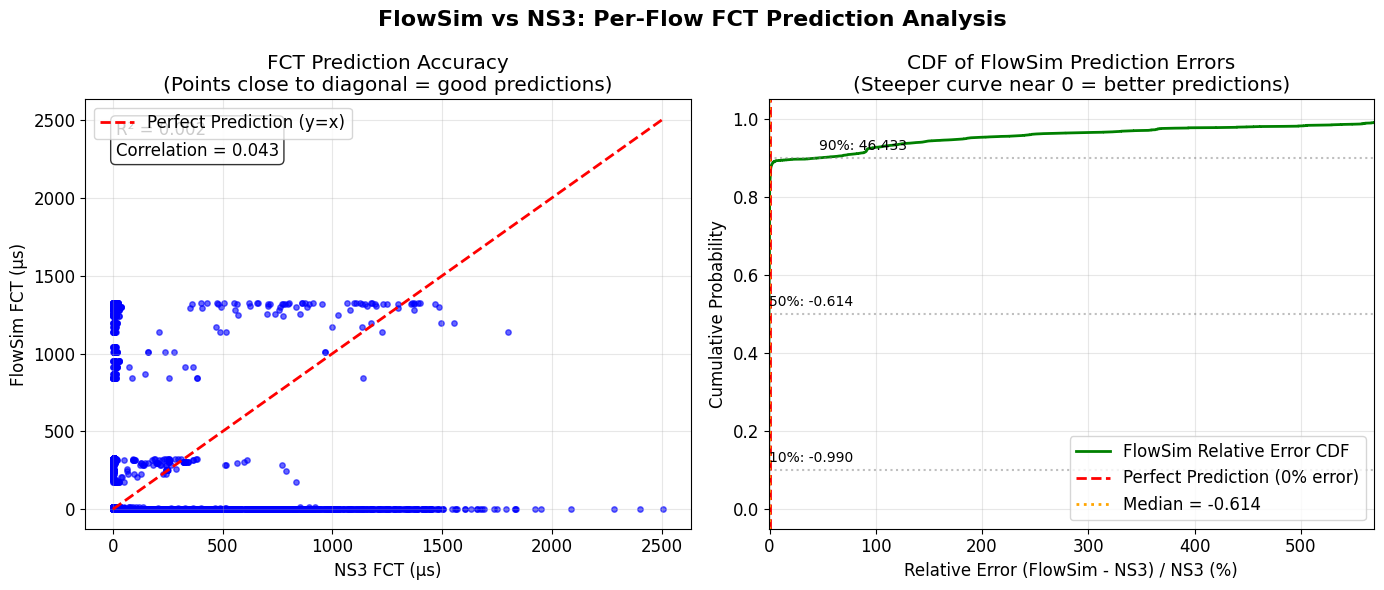


📊 SUMMARY STATISTICS (Index-Based Matching):
Total matched flows: 61,440
Mean relative error: 25.9453 (2594.53%)
Median relative error: -0.6139 (-61.39%)
Standard deviation: 99.5452
R² correlation: 0.002

📈 ABSOLUTE ERROR PERCENTILES:
10th percentile absolute error: 0.0421 (4.21%)
25th percentile absolute error: 0.4138 (41.38%)
50th percentile absolute error: 0.7464 (74.64%)
75th percentile absolute error: 0.9211 (92.11%)
90th percentile absolute error: 46.4327 (4643.27%)
95th percentile absolute error: 185.6505 (18565.05%)
99th percentile absolute error: 568.9295 (56892.95%)

⏱️ TIMING COMPARISON:
NS3 FCT:     mean=75790.7ns, median=3617.0ns
FlowSim FCT: mean=95884.1ns, median=1798.0ns
Both simulators start flows at same time: False


In [6]:
# Create the two essential plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('FlowSim vs NS3: Per-Flow FCT Prediction Analysis', fontsize=16, fontweight='bold')

# 1. Scatter plot: FlowSim vs NS3 FCT (should align along diagonal if predictions are good)
# Sample data if too many points
if len(merged_df) > 10000:
    sample_df = merged_df.sample(n=10000, random_state=42)
    print(f"Plotting sample of {len(sample_df)} flows for clarity")
else:
    sample_df = merged_df

# Convert to microseconds for better readability
ns3_fct_us = sample_df['ns3_fct'] / 1000
flowsim_fct_us = sample_df['flowsim_fct'] / 1000

ax1.scatter(ns3_fct_us, flowsim_fct_us, alpha=0.6, s=15, color='blue')

# Perfect prediction line (diagonal)
min_fct = min(ns3_fct_us.min(), flowsim_fct_us.min())
max_fct = max(ns3_fct_us.max(), flowsim_fct_us.max())
ax1.plot([min_fct, max_fct], [min_fct, max_fct], 'r--', linewidth=2, label='Perfect Prediction (y=x)')

ax1.set_xlabel('NS3 FCT (μs)')
ax1.set_ylabel('FlowSim FCT (μs)')
ax1.set_title('FCT Prediction Accuracy\n(Points close to diagonal = good predictions)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Calculate and display correlation
correlation = np.corrcoef(sample_df['ns3_fct'], sample_df['flowsim_fct'])[0,1]
r_squared = correlation ** 2
ax1.text(0.05, 0.95, f'R² = {r_squared:.3f}\nCorrelation = {correlation:.3f}', 
         transform=ax1.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         verticalalignment='top')

# 2. CDF of relative errors
sorted_errors = np.sort(merged_df['relative_error'])
cdf_y = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

ax2.plot(sorted_errors, cdf_y, linewidth=2, color='green', label='FlowSim Relative Error CDF')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction (0% error)')
ax2.axvline(merged_df['relative_error'].median(), color='orange', linestyle=':', linewidth=2, 
           label=f'Median = {merged_df["relative_error"].median():.3f}')

# Add key percentiles
percentiles = [0.1, 0.5, 0.9]
for p in percentiles:
    val = np.percentile(merged_df['relative_error'], p*100)
    ax2.axhline(p, color='gray', linestyle=':', alpha=0.5)
    ax2.text(val, p + 0.02, f'{p*100:.0f}%: {val:.3f}', fontsize=10)

ax2.set_xlabel('Relative Error (FlowSim - NS3) / NS3 (%)')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('CDF of FlowSim Prediction Errors\n(Steeper curve near 0 = better predictions)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(np.percentile(merged_df['relative_error'], 1), np.percentile(merged_df['relative_error'], 99))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📊 SUMMARY STATISTICS (Index-Based Matching):")
print(f"Total matched flows: {len(merged_df):,}")
print(f"Mean relative error: {merged_df['relative_error'].mean():.4f} ({merged_df['relative_error'].mean()*100:.2f}%)")
print(f"Median relative error: {merged_df['relative_error'].median():.4f} ({merged_df['relative_error'].median()*100:.2f}%)")
print(f"Standard deviation: {merged_df['relative_error'].std():.4f}")
print(f"R² correlation: {r_squared:.3f}")

# Error percentiles (using absolute values for percentiles)
abs_errors = np.abs(merged_df['relative_error'])
print(f"\n📈 ABSOLUTE ERROR PERCENTILES:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    val = np.percentile(abs_errors, p)
    print(f"{p}th percentile absolute error: {val:.4f} ({val*100:.2f}%)")

# Show timing comparison
print(f"\n⏱️ TIMING COMPARISON:")
print(f"NS3 FCT:     mean={merged_df['ns3_fct'].mean():.1f}ns, median={merged_df['ns3_fct'].median():.1f}ns")
print(f"FlowSim FCT: mean={merged_df['flowsim_fct'].mean():.1f}ns, median={merged_df['flowsim_fct'].median():.1f}ns")

# Check if both start at same time
same_start = (merged_df['ns3_start'] == merged_df['flowsim_start']).all()
print(f"Both simulators start flows at same time: {same_start}")
if same_start:
    print(f"Common start time: {merged_df['ns3_start'].iloc[0]}ns")